In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, Dropout
import tensorflow_datasets as tfds
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

news = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"))
news_df = pd.DataFrame({"text": news.data, "category": news.target})
news_df['category_name'] = news_df['category'].map(lambda x: news.target_names[x])
news_df.head()


,text,category,category_name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

train_df= news_df.copy()

# **VADER  score**:
VADER uses a sentiment lexicon with words annotated with a sentiment score ranging from -4 to 4,

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Add word count and character count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
train_df['char_count'] = train_df['text'].apply(len)

# Calculate VADER sentiment scores
train_df['vader_scores'] =train_df['text'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)


## **Data Preprocessing**
- Removes generic words (e.g., would, could, well, also, much, many, even, still, always, get, take, thing).
- Lemmatizes words to unify different forms (running, runs, ran → run).
- Removes non-essential POS tags like adverbs (RB), conjunctions (CC), determiners (DT), and auxiliary verbs (MD).
- Keeps important nouns and verbs to preserve meaning.
- Cleans text without over-filtering punctuation (keeps spaces, removes unwanted symbols).

In [ ]:
nltk.download('all')

In [29]:
import nltk
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Expanded stopword list
custom_stopwords = set(stopwords.words("english")) | {
    "would", "could", "like", "well", "also", "way", "may",
    "much", "many", "even", "still", "always", "get", "take", "thing",'ax','one','good'
}

# POS tags to remove
excluded_pos_tags = {"RB", "DT", "IN", "CC", "MD", "PRP", "WP", "EX"}

def get_wordnet_pos(tag):
    """Convert POS tag to WordNet format for lemmatization."""
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    """Cleans text by removing HTML, URLs, and unwanted symbols."""
    text = re.sub("<[^>]*>", "", text)  # Remove HTML tags
    text = re.sub(r"http[s]?://\S+", "", text)  # Remove URLs
    text = unicodedata.normalize("NFKD", text)  # Normalize special characters
    text = re.sub(r"[^\w\s]", "", text)  # Remove non-word characters but keep spaces
    return text

def preprocess_text(text):
    """Full preprocessing pipeline for text cleaning and filtering."""
    text = clean_text(text)  # Initial text cleaning
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)  # Tokenize text
    tagged_words = pos_tag(words)  # POS tagging

    filtered_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged_words
        if word not in custom_stopwords and  # Remove stopwords
           len(word) > 1 and  # Remove single characters
           not word.isdigit() and  # Remove numbers
           tag not in excluded_pos_tags  # Remove unnecessary POS
    ]

    return " ".join(filtered_words)

train_df["cleaned_text"] = train_df["text"].apply(preprocess_text)
train_df["word_count"] = train_df["cleaned_text"].str.split().str.len()

print("Number of empty sentences:", (train_df["word_count"] == 0).sum())
print("Average words per sentence:", train_df["word_count"].mean())
print("\nSample of very short cleaned texts:")
print(train_df[train_df["word_count"] < 3][["text", "cleaned_text"]].head())


Number of empty sentences: 1
Average words per sentence: 85.65664461815996

Sample of very short cleaned texts:
                                               text  \
99               Just opened up the distribution.\n   
174                            please subscrive me.   
200  \nJesus did and so do I.\n\nPeace be with you,   
206    Inguiry by address:er1@eridan.chuvashia.su\n   
335           \nsubscribe min@stella.skku.ac.kr\n\n   

                            cleaned_text  
99                     open distribution  
174                     please subscrive  
200                          jesus peace  
206  inguiry addresser1eridanchuvashiasu  
335          subscribe minstellaskkuackr  


In [9]:
# Remove rows where cleaned_text is empty or just whitespace
train_df = train_df[train_df['cleaned_text'].str.strip() != '']
train_df[train_df["cleaned_text"]=='']

,text,category,category_name,word_count,char_count,vader_scores,cleaned_text


In [30]:
train_df[['text','cleaned_text']].head(10)

,text,cleaned_text
0,\n\nI am sure some bashers of Pens fans are pr...,sure bashers pen fan confuse lack kind post re...
1,My brother is in the market for a high-perform...,brother market highperformance video card supp...
2,\n\n\n\n\tFinally you said what you dream abou...,say dream mediterranean new area great year ho...
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,think scsi card dma transfer disk scsi card dm...
4,1) I have an old Jasmine drive which I cann...,old jasmine drive use new system understanding...
5,\n\nBack in high school I worked as a lab assi...,high school work lab assistant bunch experimen...
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,ae dallastry tech support line start
7,"\n[stuff deleted]\n\nOk, here's the solution t...",stuff delete ok heres solution problem move ca...
8,"\n\n\nYeah, it's the second one. And I believ...",second believe price ive try look bruinsabre t...
9,\nIf a Christian means someone who believes in...,christian mean someone believe divinity jesus ...


# **Perform EDA**

In [11]:
def create_length_distribution_plot():
    """Create interactive distribution plot for review lengths"""
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=train_df['word_count'],
        name='Word Count Distribution',
        nbinsx=100
    ))
    fig.update_layout(
        title='Distribution of Review Lengths',
        xaxis_title='Word Count',
        yaxis_title='Frequency'
    )
    fig.show()

def create_sentiment_distribution_plot():
    """Create interactive sentiment distribution plot"""
    fig = go.Figure()
    fig.add_trace(go.Violin(
        y=train_df['vader_scores'],
        box_visible=True,
        line_color='black',
        name='Sentiment Distribution'
    ))
    fig.update_layout(
        title='Distribution of Sentiment Scores',
        yaxis_title='VADER Sentiment Score'
    )
    fig.show()

def create_wordcloud():
    """Generate and display word cloud"""
    all_words = ' '.join(train_df['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Reviews')
    plt.show()


In [ ]:
create_length_distribution_plot()


In [13]:
create_sentiment_distribution_plot()

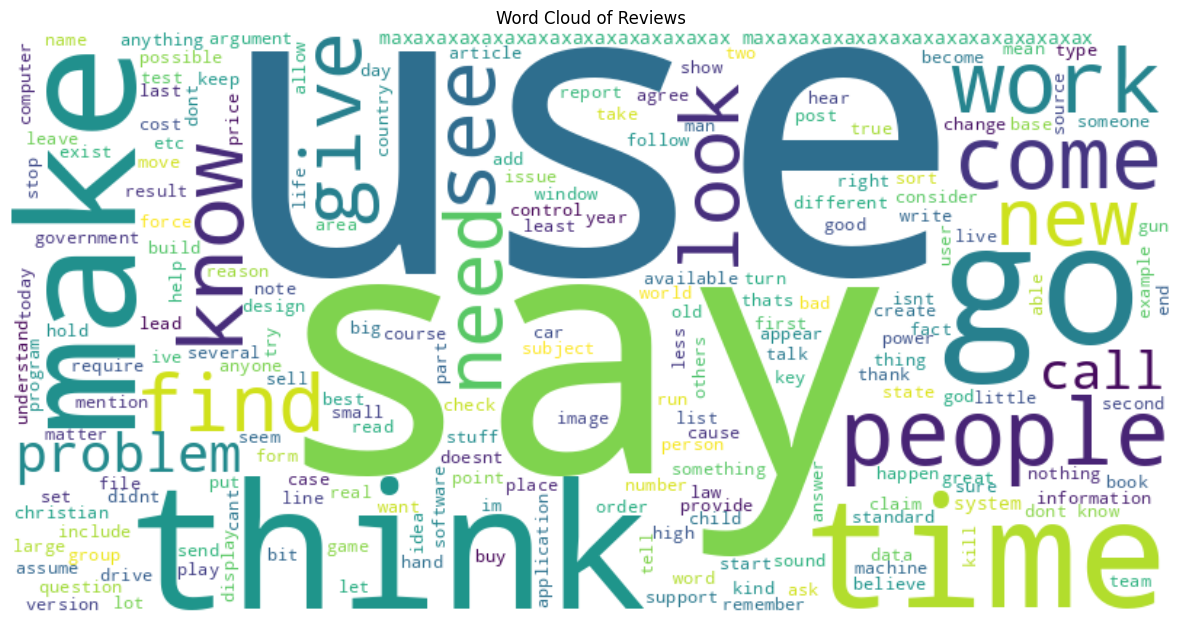

In [31]:
create_wordcloud()

In [15]:
import plotly.express as px

fig = px.histogram(train_df, x="category_name", nbins=20, title="Category Distribution",
                   labels={"category": "category_name"}, opacity=0.7)
fig.update_layout(bargap=0.2)
fig.show()


# **TF-IDF**
- The TF-IDF algorithm measures two factors: the frequency of a word in a document (TF) and the frequency of the word across all documents in the corpus (IDF). The term frequency (TF) is a measure of how frequently a term appears in a document.
- (TFIDF) is a statistical formula to convert text documents into vectors based on the relevancy of the word. It is based on the bag of the words model to create a matrix containing the information about less relevant and most relevant words in the document.

# **KMeans clustering**
- K-means groups together similar data points. The aim of the k-means algorithm is to minimize the total distances between points and their assigned cluster centroid.
- Type of unsupervised learning, which is used for unlabeled data.
- Simple, fast algorithm that is generally unaffected by extremes and outliers.


- Both ARI (Adjusted Rand Index) and NMI (Normalized Mutual Information) measure clustering quality by comparing clusters with true labels.


```
Metric	   Range	        Good Score
ARI     	-1 to 1	       > 0.5 (Strong agreement)
NMI	      0 to 1	       > 0.6 (Good match)

ARI ≈ 0 means clusters are random.
ARI > 0.5 indicates clusters align well with labels.
NMI > 0.6 suggests good cluster separation.
```
- For unsupervised sentiment analysis, we usually aim for:
  - ARI ≥ 0.3 (decent for text data)
  - NMI ≥ 0.5 (clusters contain meaningful info)


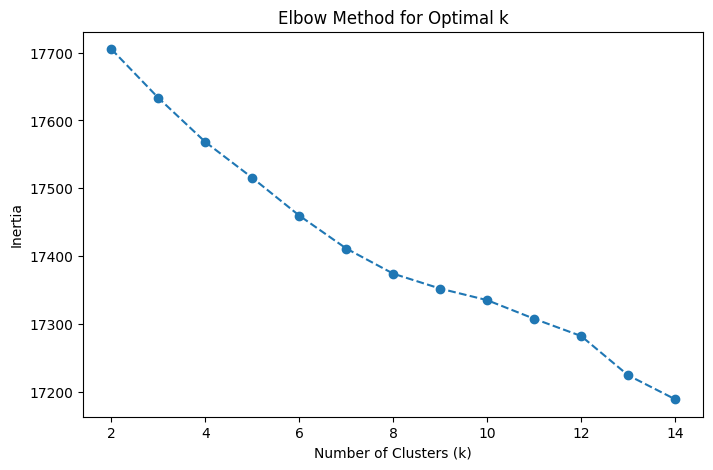

In [32]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

tfidf = TfidfVectorizer(max_features=2000)
tfidf_matrix = tfidf.fit_transform(train_df["cleaned_text"])

inertia = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Plot inertia vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


In [ ]:
pip install kneed

In [33]:
from kneed import KneeLocator

knee_locator = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

print(f"Optimal k found: {optimal_k}")


Optimal k found: 7


In [34]:
optimal_k = 7

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
train_df["knn_cluster"] = kmeans.fit_predict(tfidf_matrix)


In [35]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

fig = px.scatter(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    color=train_df["knn_cluster"].astype(str),
    title="Review Clusters based on Content Similarity",
    labels={"color": "Cluster"},
)
fig.show()


In [36]:
import numpy as np

# Get top words per cluster
def get_top_keywords_per_cluster(tfidf_matrix, clusters, feature_names, top_n=10):
    cluster_centers = kmeans.cluster_centers_
    top_words = {}

    for cluster_idx in range(optimal_k):
        top_word_indices = np.argsort(cluster_centers[cluster_idx])[-top_n:]
        top_words[cluster_idx] = [feature_names[i] for i in top_word_indices]

    return top_words

feature_names = tfidf.get_feature_names_out()
top_words = get_top_keywords_per_cluster(tfidf_matrix, train_df["knn_cluster"], feature_names)


for cluster, words in top_words.items():
    print(f"\n🟢 Cluster {cluster} Keywords: {', '.join(words)}")



🟢 Cluster 0 Keywords: version, work, driver, problem, run, program, card, use, file, window

🟢 Cluster 1 Keywords: see, go, know, right, make, government, think, dont, say, people

🟢 Cluster 2 Keywords: last, go, season, win, hockey, year, play, player, team, game

🟢 Cluster 3 Keywords: faith, church, bible, sin, christ, say, believe, jesus, christian, god

🟢 Cluster 4 Keywords: reply, im, look, hi, advance, know, anyone, email, please, thanks

🟢 Cluster 5 Keywords: system, problem, use, ide, floppy, controller, hard, disk, scsi, drive

🟢 Cluster 6 Keywords: get, time, dont, know, new, make, car, go, think, use


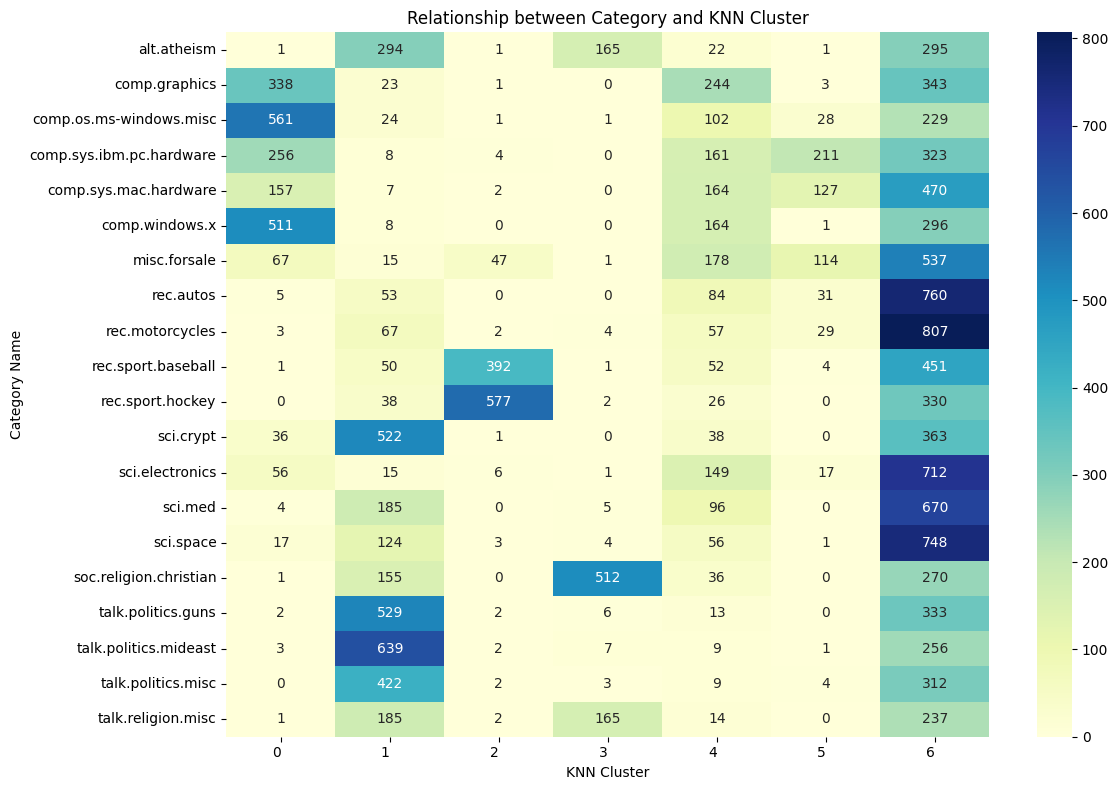

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cluster_category_ct = pd.crosstab(train_df['category_name'], train_df['knn_cluster'])

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_category_ct, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Relationship between Category and KNN Cluster")
plt.xlabel("KNN Cluster")
plt.ylabel("Category Name")
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

# **Observations:**
- Cluster 0 appears to group together all the harware and electronics related articles.
- Cluster 1 is dominated by politics and religion topics.
- Cluster 2 is all about sports.
- Cluster 3 contains mostly religion related news, overlapping with cluster 1.
- Clusters 4,5 and 6 have mixed topics.
- The clusters are not evenly populated. Most news lie in cluster 6.

# **DBSCAN clustering with BERT embeddings**
### **DBSCAN Clustering**  
DBSCAN (**Density-Based Spatial Clustering of Applications with Noise**) is a **density-based clustering algorithm** that groups data points based on their density.  

- **Finds dense regions** and groups them into clusters.  
- **Does not require specifying the number of clusters** (unlike KMeans).  
- **Can detect noise (outliers)** instead of forcing all points into clusters.  
- Uses two key parameters:  
  - **ε (epsilon)** → Defines how close points must be to be considered neighbors.  
  - **min_samples** → Minimum points needed to form a dense region (cluster).  
- Works **well for high-dimensional embeddings** (e.g., BERT).  
- Can **discover natural groupings** (topics) instead of forcing a fixed number.  
- Can **handle noise** (irrelevant or vague reviews).  

---

### **BERT Embeddings**  
BERT (**Bidirectional Encoder Representations from Transformers**) is a deep learning model that creates **contextual word embeddings**.  
- They are **vector representations of text**, capturing **meaning** and **context**.  
- Unlike TF-IDF, **BERT understands synonyms & context** (e.g., "bank" as a financial institution vs. a riverbank).  
- Converts reviews into **dense numerical vectors**, making clustering more meaningful.  
- **Understands context** better than simple word frequency methods (TF-IDF).  
- Works well with **DBSCAN** since it finds natural clusters in high-dimensional space.  

---

### **Why Use DBSCAN + BERT Here?**  
1. **We don’t know the exact number of clusters** → DBSCAN finds natural clusters without predefining them.  
2. **Reviews may contain noise** → DBSCAN can ignore irrelevant reviews instead of forcing them into a category.  
3. **Sentiment-based clustering is unclear** → BERT embeddings help capture review **semantics**, making clustering more meaningful.  
4. **We want a more flexible model** → Unlike KMeans, DBSCAN doesn’t assume clusters are spherical (it handles non-uniform shapes).  


In [ ]:
!pip install transformers sentence-transformers scikit-learn scipy nltk tensorflow_datasets

In [38]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
train_sentences = train_df["cleaned_text"].tolist()
train_embeddings = model.encode(train_sentences, convert_to_numpy=True, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/572 [00:00<?, ?it/s]

Finding optimal epsilon...


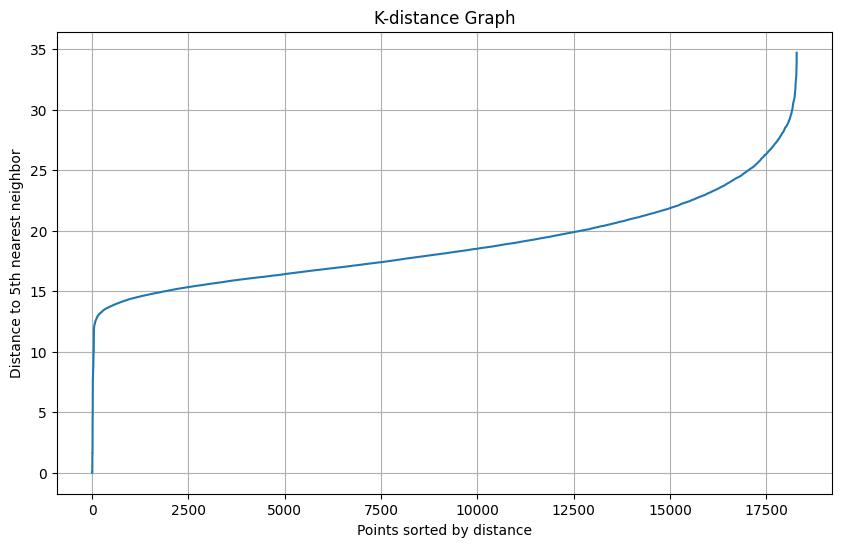

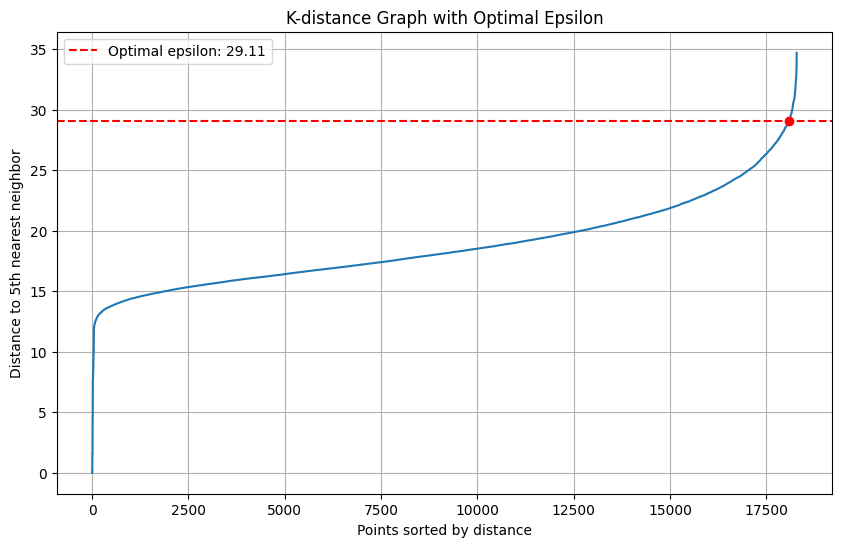

Optimal epsilon: 29.1082

Performing DBSCAN clustering...

Creating visualizations...


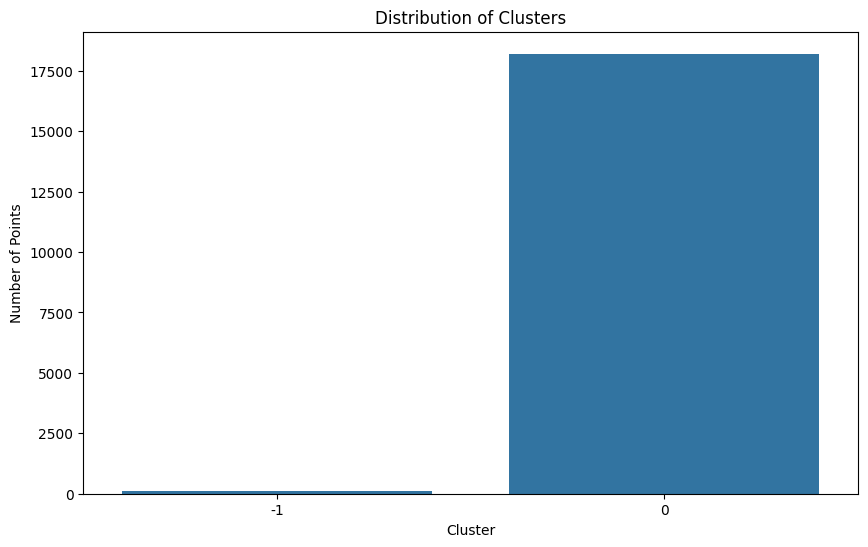


Analyzing clustering results...

Clustering Results:
Number of clusters: 1
Number of noise points: 92
Percentage of noise points: 0.50%

Cluster sizes:
Cluster -1: 92 points
Cluster 0: 18201 points


In [39]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from kneed import KneeLocator

def find_optimal_epsilon(data, min_samples, n_neighbors=5):
    """
    Find optimal epsilon using k-nearest neighbors distance plot

    Args:
        data: feature matrix
        min_samples: min_samples parameter for DBSCAN
        n_neighbors: number of neighbors to consider (default: 5)

    Returns:
        optimal epsilon value
    """
    # Calculate distances to nearest neighbors
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)

    # Sort distances in ascending order
    distances = np.sort(distances[:, -1])

    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(distances)), distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {n_neighbors}th nearest neighbor')
    plt.title('K-distance Graph')
    plt.grid(True)
    plt.show()

    # Find elbow point using KneeLocator
    kneedle = KneeLocator(
        range(len(distances)),
        distances,
        S=1.0,
        curve='convex',
        direction='increasing'
    )

    optimal_epsilon = distances[kneedle.knee]

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(distances)), distances)
    plt.axhline(y=optimal_epsilon, color='r', linestyle='--',
                label=f'Optimal epsilon: {optimal_epsilon:.2f}')
    plt.plot(kneedle.knee, distances[kneedle.knee], 'ro')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {n_neighbors}th nearest neighbor')
    plt.title('K-distance Graph with Optimal Epsilon')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_epsilon

def perform_dbscan_clustering(data, epsilon, min_samples):
    """
    Perform DBSCAN clustering with given parameters

    Args:
        data: feature matrix
        epsilon: epsilon parameter for DBSCAN
        min_samples: min_samples parameter for DBSCAN

    Returns:
        cluster labels and DBSCAN model
    """
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)
    return clusters, dbscan

def visualize_clusters(data, clusters):
    """
    Create visualizations for clustering results

    Args:
        data: feature matrix
        clusters: cluster labels
    """
    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(data)

    # Create DataFrame for plotting
    df_plot = pd.DataFrame({
        'x': reduced_features[:, 0],
        'y': reduced_features[:, 1],
        'cluster': clusters
    })

    # Interactive scatter plot with Plotly
    fig = px.scatter(
        df_plot,
        x='x',
        y='y',
        color='cluster',
        title='DBSCAN Clustering Results (PCA)',
        labels={'x': 'First Principal Component',
                'y': 'Second Principal Component'},
        color_continuous_scale='viridis'
    )
    fig.show()

    # Plot cluster distribution
    plt.figure(figsize=(10, 6))
    cluster_counts = pd.Series(clusters).value_counts().sort_index()
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
    plt.title('Distribution of Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Points')
    plt.show()

def analyze_clusters(data, clusters):

    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)

    metrics = {
        'n_clusters': n_clusters,
        'n_noise_points': n_noise,
        'noise_percentage': n_noise / len(clusters) * 100,
        'cluster_sizes': pd.Series(clusters).value_counts().sort_index().to_dict()
    }

    return metrics

# Main clustering pipeline
def run_dbscan_analysis(data, min_samples=5):

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Find optimal epsilon
    print("Finding optimal epsilon...")
    epsilon = find_optimal_epsilon(scaled_data, min_samples)
    print(f"Optimal epsilon: {epsilon:.4f}")

    # Perform clustering
    print("\nPerforming DBSCAN clustering...")
    clusters, dbscan = perform_dbscan_clustering(scaled_data, epsilon, min_samples)

    print("\nCreating visualizations...")
    visualize_clusters(scaled_data, clusters)

    print("\nAnalyzing clustering results...")
    metrics = analyze_clusters(scaled_data, clusters)

    print("\nClustering Results:")
    print(f"Number of clusters: {metrics['n_clusters']}")
    print(f"Number of noise points: {metrics['n_noise_points']}")
    print(f"Percentage of noise points: {metrics['noise_percentage']:.2f}%")
    print("\nCluster sizes:")
    for cluster, size in metrics['cluster_sizes'].items():
        print(f"Cluster {cluster}: {size} points")

    return clusters, metrics

clusters, metrics = run_dbscan_analysis(train_embeddings)

In [40]:
epsilon = 0.02
min_samples = 10
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
train_df['DBSCAN_clusters'] = dbscan.fit_predict(train_embeddings)

In [41]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(train_embeddings)

fig = px.scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    color=train_df["DBSCAN_clusters"].astype(str),
    title="DBSCAN Clustering of IMDb Reviews",
    labels={"color": "Cluster"}
)
fig.show()


# **Hierarchical clustering**

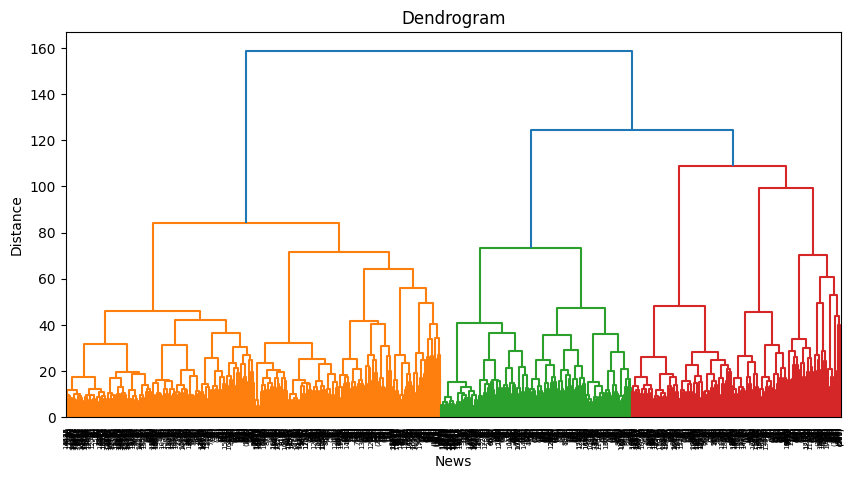

In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

linkage_matrix = linkage(train_embeddings, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, truncate_mode="level", p=10)
plt.title("Dendrogram")
plt.xlabel("News")
plt.ylabel("Distance")
plt.show()


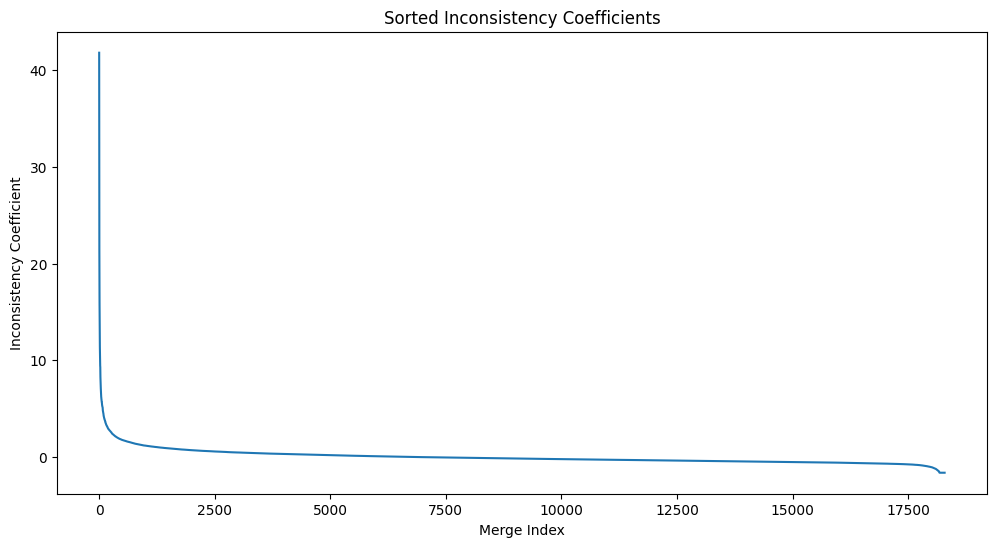


Optimal Cluster Analysis Results:
1. Elbow Method suggests 8 clusters
2. Silhouette Analysis suggests 2 clusters
3. Dendrogram Analysis: Check the dendrogram plot for major splits


In [43]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go

def find_optimal_clusters(embeddings, max_clusters=20):
    """
    Find optimal number of clusters using multiple methods:
    1. Elbow method using distortion
    2. Silhouette analysis
    3. Dendrogram analysis
    """

    # Calculate distortion scores (within-cluster sum of squares)
    distortions = []
    silhouette_scores = []
    n_clusters_range = range(2, max_clusters + 1)

    for n_clusters in n_clusters_range:
        cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

        # Calculate distortion
        distortion = 0
        for i in range(1, n_clusters + 1):
            cluster_points = embeddings[cluster_labels == i]
            centroid = np.mean(cluster_points, axis=0)
            distortion += np.sum((cluster_points - centroid) ** 2)
        distortions.append(distortion)

        # Calculate silhouette score
        if len(np.unique(cluster_labels)) > 1:  # Silhouette requires at least 2 clusters
            silhouette_scores.append(silhouette_score(embeddings, cluster_labels))
        else:
            silhouette_scores.append(0)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(n_clusters_range),
                            y=distortions,
                            mode='lines+markers',
                            name='Distortion'))

    kn = KneeLocator(list(n_clusters_range),
                     distortions,
                     curve='convex',
                     direction='decreasing')
    elbow_point = kn.knee

    fig.add_trace(go.Scatter(x=[elbow_point],
                            y=[distortions[elbow_point-2]],
                            mode='markers',
                            marker=dict(size=15, color='red'),
                            name=f'Elbow Point (k={elbow_point})'))

    fig.update_layout(title='Elbow Method for Optimal k',
                     xaxis_title='Number of Clusters (k)',
                     yaxis_title='Distortion Score',
                     showlegend=True)
    fig.show()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(n_clusters_range),
                            y=silhouette_scores,
                            mode='lines+markers',
                            name='Silhouette Score'))

    # Find optimal k using silhouette score
    optimal_k_silhouette = n_clusters_range[np.argmax(silhouette_scores)]

    fig.add_trace(go.Scatter(x=[optimal_k_silhouette],
                            y=[max(silhouette_scores)],
                            mode='markers',
                            marker=dict(size=15, color='red'),
                            name=f'Optimal k={optimal_k_silhouette}'))

    fig.update_layout(title='Silhouette Scores for Different k',
                     xaxis_title='Number of Clusters (k)',
                     yaxis_title='Silhouette Score',
                     showlegend=True)
    fig.show()

    # Calculate inconsistency coefficients
    def get_inconsistency(linkage_matrix):
        n = len(linkage_matrix) + 1
        heights = linkage_matrix[:, 2]
        mean_heights = np.mean(heights)
        std_heights = np.std(heights)
        inconsistency = (heights - mean_heights) / std_heights if std_heights > 0 else heights
        return inconsistency

    inconsistency = get_inconsistency(linkage_matrix)

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(inconsistency)), sorted(inconsistency, reverse=True))
    plt.title('Sorted Inconsistency Coefficients')
    plt.xlabel('Merge Index')
    plt.ylabel('Inconsistency Coefficient')
    plt.show()

    print("\nOptimal Cluster Analysis Results:")
    print(f"1. Elbow Method suggests {elbow_point} clusters")
    print(f"2. Silhouette Analysis suggests {optimal_k_silhouette} clusters")
    print("3. Dendrogram Analysis: Check the dendrogram plot for major splits")

    return {
        'elbow_k': elbow_point,
        'silhouette_k': optimal_k_silhouette,
        'distortions': distortions,
        'silhouette_scores': silhouette_scores,
        'linkage_matrix': linkage_matrix
    }

def apply_clustering(embeddings, n_clusters, linkage_matrix=None):
    """
    Apply hierarchical clustering with the optimal number of clusters
    """
    if linkage_matrix is None:
        linkage_matrix = linkage(embeddings, method="ward")

    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()

    print("\nCluster Statistics:")
    print(f"Number of clusters: {n_clusters}")
    print("\nCluster sizes:")
    for cluster, size in cluster_sizes.items():
        print(f"Cluster {cluster}: {size} samples")

    return cluster_labels


results = find_optimal_clusters(train_embeddings, max_clusters=20)
n_clusters = results['elbow_k']  # or results['silhouette_k']


In [50]:

num_clusters = 8
clusters = fcluster(linkage_matrix, num_clusters, criterion="maxclust")

train_df["h_cluster"] = clusters


In [51]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(train_embeddings)

fig = px.scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    color=train_df["h_cluster"].astype(str),
    title="Hierarchical clustering",
    labels={"color": "Cluster"}
)
fig.show()


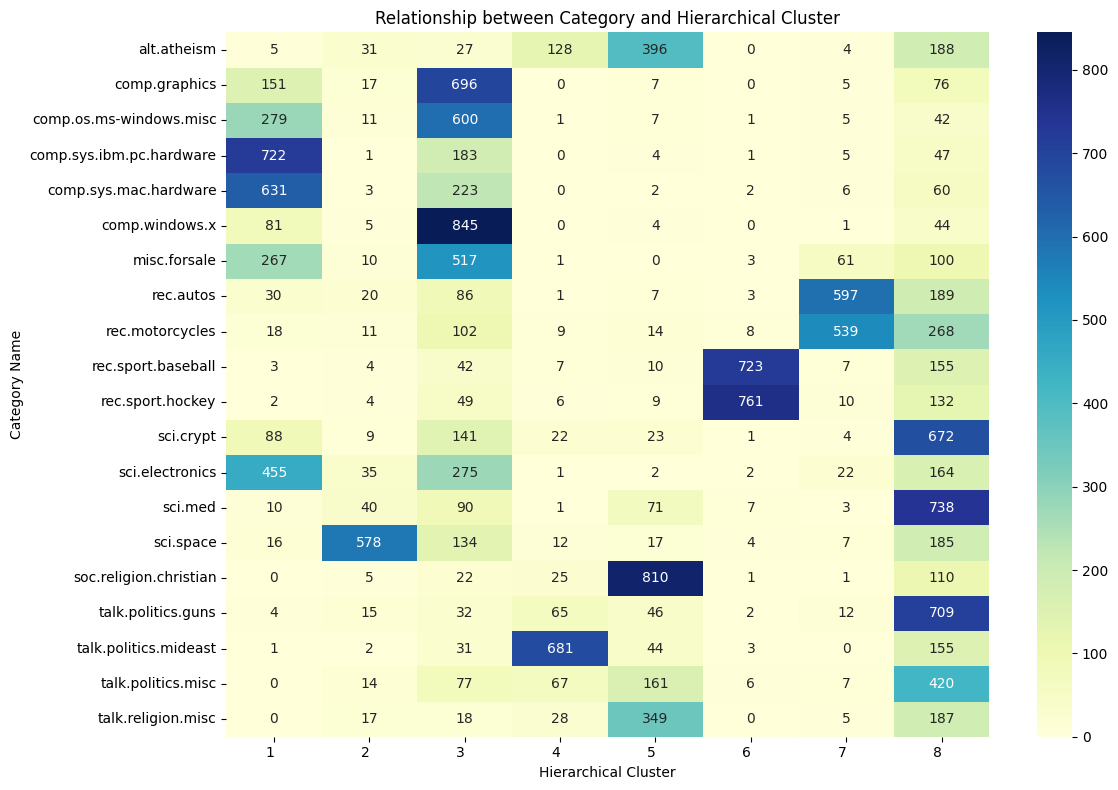

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cluster_category_ct = pd.crosstab(train_df['category_name'], train_df['h_cluster'])

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_category_ct, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Relationship between Category and Hierarchical Cluster")
plt.xlabel("Hierarchical Cluster")
plt.ylabel("Category Name")
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

# **Observations:**
- Cluster 1 appears to group together all the harware and electronics related articles.
- Cluster 2 is dominated by the space field.
- Cluster 3 overlaps with cluster 1. However, it is dominated by windows and graphics news while cluster 1 concentrates more on hardware.
- Cluster 4 contains mostly politics related news.
- Cluster 5 has articles about religion and very few on politics.
- Cluster 6 is all about sports.
- Cluster 7 contains everything on vehicles, motocyles and cars.
- Cluster 8 is a mix of everything, with a great focus on medicine and politics again. This appears to be the largest cluster.
- The clusters are well populated and separetd between them. Some overlap is expected since many of the topics naturally are linked between them.
- The clustering here clearly is better compared to KNN method.